<a href="https://colab.research.google.com/github/yehuda-yu/ML_Projects/blob/main/Rocks_DNN_Classification_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Course 70938 - Machine learning in earth and environmental sciences
## Assignment04 - Artificial neural networks (fully connected)
### Lecturer: Efrat Morin (Institute of Earth Sciences, Hebrew University)

The first notebook cell should be a text cell with the following details: Your name, ID num, course number, assignment number

In this assignment, you will develop a rock classifier
Data were taken from [Kaggle](https://doi.org/10.34740/KAGGLE/DS/1293628): Shahriar Hossain, Jahir Uddin, &amp; Rakibul Alam Nahin. (2021). <i>Rock Classification Dataset</i> [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DS/1293628

It includes the following stages:
- Custom dataset
- Define, train and evaluate the model using the training and validation datasets
- Tune hyperparameters and network's architecture
- Evaluate the final model with the test dataset

# Prelminraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import transforms
from torchvision.io import read_image

Setting global parameters:

In [ ]:
# This pathroot assumes the images are in subfolders of the following path, each sub-folder is the class name.
# Make sure your data is in the expected file structure.
PATH_ROOT = "/content/drive/MyDrive/gdrive_folder/Courses/course70938ML/HW/Assingment04/Rocks/" 

IMG_H = 100 # Image height after resize
IMG_W = 100 # Image width after resize
IMG_CH = 3 # Channel number
CLASS_NUM = 7 # Number of classes (number of sub-folders with jpg files in PATH_ROOT)

# Since reading image and label data takes time, after first time you can save
# it as numpy array file and then the data from this file.  
data_numpy_was_saved = True # Set this to True if you already saved the data
path_numpy_arrays = PATH_ROOT+'rocks.npz' # Path of the numpy array file

# Defining and initializing the dataset


`torch.utils.data.Dataset` is an abstract class representing a dataset. It inherits Dataset and must implement three functions: `__init__`, `__len__`, and `__getitem__`.
- The `__init__` function is run once when instantiating the Dataset object. Here we will read the image data and the labels, arrange them in numpy arrays and define other parameters. Note the images are arranged in folders where the folder name is the class name. Also, the images are in different sizes so we use `resize` to be of equal sizes. If the data was already saved to a file of numpy arrays we will read the image and label data from this file. 
- The `__len__` function returns the number of samples in our datasets.
- The `__getitem__` function returns a sample from the dataset at the given index `idx`. Based on the index, it converts the relevant image and label to tensors, calls the transform functions on them (if applicable), and returns the
tensor image and corresponding label in a tuple.


TODO: You should write the `__getitem__` and `__len__` methods. You can base it on Tutoring06, but note how the image and label data are kept in our case (see `__init__`).

In [ ]:
class Rocks(Dataset):

  def __init__(self, root_data_path, load_imageandlabels=True, 
               path_numpy_arrays=None, transform=None, target_transform=None):
    path = os.path.join(root_data_path,'*','*.jpg')
    self.classes = []
    text = glob.glob(os.path.join(root_data_path,'*'))
    for t in text:
      cl = t.split('/')[-1]
      self.classes.append(cl)        
    if load_imageandlabels == True:
      data_path = glob.glob(path)
      lst = []
      self.labels = [] 
      for img_path in data_path:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(IMG_W, IMG_H)) # The images may be in different sizes
        lst.append(img)
        cl = img_path.split('/')[-2]
        la = self.classes.index(cl)
        self.labels.append(la)
      self.data = np.stack(lst, axis=0)
      if path_numpy_arrays is not None:
        np.savez(path_numpy_arrays, self.data, self.labels)
    else:
      if path_numpy_arrays is not None:
        npzfile = np.load(path_numpy_arrays)
        self.data = npzfile['arr_0']
        self.labels= npzfile['arr_1']

    self.transform = transform
    self.target_transform = target_transform

  def __getitem__(self, idx): 
    img = self.data[idx]
    lbl = self.labels[idx]
    if self.transform:
      img = self.transform(img)
    if self.target_transform:
      lbl = self.target_transform(lbl)
    return img, lbl
  
  def __len__(self): 
    return len(self.labels)

Transforms include moving the image into a tensor and normalizing it.

Note that `transforms.ToTensor` Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] (the scaling depends on the image type). 

Note that, in principle, the Normalize transform intends to standardize the data by subtracting the mean and dividing by std, per channel. This requires the computation of the mean and std from the training dataset. Here we just use 0.5 for the mean and 0.29 for std, for all channels, which are taken from the moments of the uniform distribution between 0 and 1. These should be good enough for data normalization.

The labels are just transferred from numpy to tensor.

In [ ]:
image_transform = transforms.Compose([
      transforms.ToTensor(), 
      transforms.transforms.Normalize((0.5, 0.5, 0.5), (0.29, 0.29, 0.29))
                                      ])
target_transform = transforms.Lambda(lambda y: torch.tensor(y))

Initializing the dataset

In [ ]:
if data_numpy_was_saved:
  all_data_dataset = Rocks(PATH_ROOT, load_imageandlabels=False, path_numpy_arrays=path_numpy_arrays,
                           transform=image_transform, target_transform=target_transform)
else:
  all_data_dataset = Rocks(PATH_ROOT, load_imageandlabels=True, path_numpy_arrays=path_numpy_arrays,  
                           transform=image_transform, target_transform=target_transform)
  data_numpy_was_saved = True


# Defining, training and evaluating the model


We want to be able to train our model on a hardware accelerator like the GPU,
if it is available. Let's check to see if
[torch.cuda](https://pytorch.org/docs/stable/notes/cuda.html) is available, else we
continue to use the CPU.



In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available()
  else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.


Hyperparameters

You can tune their values to improve performance.

You also can add more hyperparameters, as needed.


In [ ]:
learning_rate = 0.001
batch_size = 64
epoch_num = 50

``DataLoader`` wraps an iterable around a ``Dataset`` to enable easy access to the samples. It allows batching, shuffling and parallelizing.

Note that our dataset includes all data and it is not a-priory divided into train, validation and test, so we will create separate loaders for each group by splitting randomly shuffled data indices.

In [ ]:
train_validation_split = 0.70 
validation_test_split = 0.85 
shuffle_dataset = True
random_seed = 10 # Make this None to have a different shuffling each run

# Creating random data indices for training, validation and testing splits:
dataset_size = len(all_data_dataset)
indices = list(range(dataset_size))
split_val = int(np.floor(train_validation_split * dataset_size))
split_test = int(np.floor(validation_test_split * dataset_size))
if shuffle_dataset:
  if random_seed is not None:
    np.random.seed(random_seed)
  np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[:split_val], indices[split_val:split_test], indices[split_test:]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(all_data_dataset, batch_size=batch_size,
                                          sampler=train_sampler, pin_memory=True)
validation_loader = torch.utils.data.DataLoader(all_data_dataset, batch_size=batch_size,
                                          sampler=valid_sampler, pin_memory=True)
test_loader = torch.utils.data.DataLoader(all_data_dataset, batch_size=batch_size, 
                                          sampler=test_sampler, pin_memory=True)

TODO

Define the neural network by subclassing `nn.Module` and the `__init__` and `__forward__` methods

Follow Tutoring06 explanations. 

Note the input size can be defined using the parameters IMG_CH, IMG_H and IMG_W. The output size can be defined using the parameter CLASS_NUM.

You can try different network's architecture. I.e., combinations of hidden layer number, number of units in the layers, and activation functions. 

If you want to to add dropout and batch normalization, you can do it using `nn.Dropout(dropout_prob)` and `nn.BatchNorm1d(num_features)` to the layers' sequence. Read documentation of both classes.

As a benchmark - start with a simple linear model without hidden layers and no activation functions. 


In [ ]:
class RockNet(nn.Module):

  def __init__(self):
    super(RockNet, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(IMG_CH*IMG_H *IMG_W, 512),
        nn.Linear(512, CLASS_NUM)
        )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

model = RockNet()

Print the model and its parameters.

Read in Pytorch documentation about parameter initialization.

In [ ]:
model = RockNet().to(device)
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: RockNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=30000, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=7, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 30000]) | Values : tensor([[ 0.0048, -0.0019,  0.0011,  ..., -0.0052,  0.0057, -0.0005],
        [-0.0045,  0.0043,  0.0031,  ..., -0.0024,  0.0038, -0.0007]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0029,  0.0045], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.1.weight | Size: torch.Size([7, 512]) | Values : tensor([[-0.0388,  0.0406, -0.0254,  ...,  0.0343,  0.0186,  0.0001],
        [ 0.0164, -0.0167,  0.0187,  ..., -0.0192,  0.0042, -0.0360]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.1.bias | Size: torch.Size([7]) | Values : tensor([-0.0324, -0.0119], grad_fn=<SliceBackward0>) 



TODO

Define the train and validation loops similarly to Tutoring06.

Make sure you fully understand each step in these loops.

Note the following modifications from the code in Tutoring06:
- You have to move the features and labels to the right device by adding these lines: X = X.to(device=device) and y = y.to(device=device).
- For some operations (like dropout) it is important to set if the model is in training (e.g., model.train()) or validation (e.g., model.eval()). Although it is not always needed, it would be safer to include these definitions before getting to the training or evaluation steps. 
- Change "test" to "validation" to follow standard naming.
- Modify printed results: for each epoch, print the average loss and the accuracy for the training or validation data. Accuracy can be computed by taking the argmax of the prediction and counting how many are the same as the labels; this value should be divided by the training/validation data length.
- The size of the training/validation dataset needs to be computed (it is not the size of the dataset from which the data loader was defined). 



In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
      model.train()
      num_batches = len(dataloader)
      size = 0
      # size = len(dataloader.dataset)
      loss_vec , correct = 0, 0
      for batch, (X, y) in enumerate(dataloader):
        # move to device 
        X = X.to(device=device) 
        y = y.to(device=device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Modify print
        loss_vec += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        size += len(y)

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            return(loss_vec/ num_batches,(correct/size)*100)


def val_loop(dataloader, model, loss_fn):
      
      model.eval()
      size = 0
      # size = len(dataloader.dataset)
      num_batches = len(dataloader)
      val_loss, correct = 0, 0
      with torch.no_grad(): 
        for X, y in dataloader:
            X = X.to(device=device) 
            y = y.to(device=device)
            pred = model(X)
            loss = loss_fn(pred, y)
            val_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            size += len(y)

      val_loss /= num_batches
      correct /= size
      print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")
      print('Validation:\n','loss = ',val_loss/ num_batches, 'accuracy = ',(correct/size)*100)
      return(val_loss/ num_batches,(correct/size)*100)

TODO

Define the loss function to be `nn.CrossEntropyLoss`. 

Define optimizer to be SGD, later you can try the Adam optimizer.
Read in the Pytorch documentation about including l2 regularization, for later steps.

Run train_loop and val_loop for the required number of epochs and print loss and accuracy for each epoch (for train and val). Keep these terms to plot learning curve.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loss_history,train_accuracy_history = [],[]
val_loss_history,val_accuracy_history = [],[]
for t in range(epoch_num):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loss , train_accuracy = train_loop(train_loader, model, loss_fn, optimizer)
  val_loss,val_accuracy = val_loop(validation_loader, model, loss_fn)
  train_loss_history.append(train_loss)
  train_accuracy_history.append(train_accuracy)
  val_loss_history.append(val_loss)
  val_accuracy_history.append(val_accuracy)
  print("\n-------------------------------")
print("Done!")

Epoch 1
-------------------------------
loss: 1.982460  [    0/   64]
Validation Error: 
 Accuracy: 26.7%, Avg loss: 1.885375 

Validation:
 loss =  0.37707502841949464 accuracy =  0.08888888888888888

-------------------------------
Epoch 2
-------------------------------
loss: 1.880909  [    0/   64]
Validation Error: 
 Accuracy: 31.0%, Avg loss: 1.835831 

Validation:
 loss =  0.3671661710739136 accuracy =  0.10333333333333333

-------------------------------
Epoch 3
-------------------------------
loss: 1.846352  [    0/   64]
Validation Error: 
 Accuracy: 31.3%, Avg loss: 1.792324 

Validation:
 loss =  0.35846485614776613 accuracy =  0.10444444444444444

-------------------------------
Epoch 4
-------------------------------
loss: 1.819920  [    0/   64]
Validation Error: 
 Accuracy: 36.3%, Avg loss: 1.750157 

Validation:
 loss =  0.350031304359436 accuracy =  0.12111111111111111

-------------------------------
Epoch 5
-------------------------------
loss: 1.740220  [    0/   6

Plot learning curves based on loss and accuracy (saved in the previous code cell)

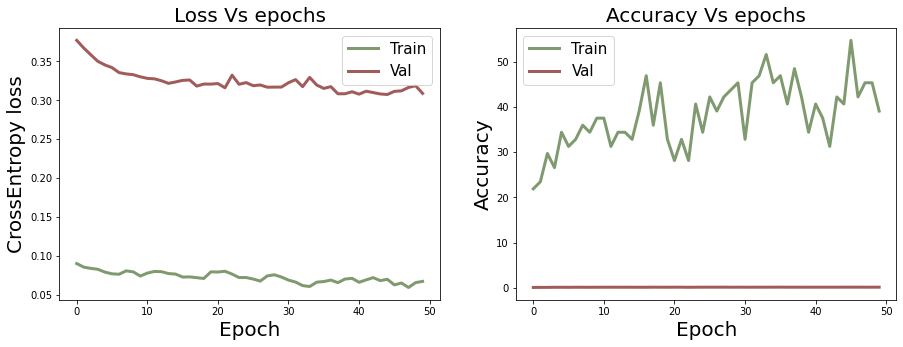

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.plot(train_loss_history,color = '#809A6F',lw=3, label='Train')
plt.plot(val_loss_history,color = '#A25B5B',lw=3, label='Val')
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('CrossEntropy loss',fontsize=20)
plt.title('Loss Vs epochs',fontsize=20)
plt.legend(fontsize=15)

plt.subplot(1,2,2)
plt.plot(train_accuracy_history,color = '#809A6F',lw=3, label='Train')
plt.plot(val_accuracy_history,color = '#A25B5B',lw=3, label='Val')
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.title('Accuracy Vs epochs',fontsize=20)
plt.legend(fontsize=15)

plt.show()

# Tune hyperparameters and network's architecture

TODO

Examine learning curves and model's performance.

Change hyperparameter values, regularization and the network structure (number of layers, unites, activation function, with/without dropout and batch-normalization, etc) to improve model's performance on the validation data set.

After some changes in the linear model we saw that the best hyperparameters where (more info in the PDF file):
1. **Learning rate** = 0.0001
2. **Epochs** = 50
3. **Batch size** = 8 

Now lets change the model architecture to find the bess model (combination of minimum loss + maximum accuracy whithout overfit). we will add some hidden layers and non linear activation function:

### **Model 1**:

In [ ]:
# Hyper-parameters
learning_rate = 0.0001
batch_size = 8
epoch_num = 50


# Model Defenition
class RockNet(nn.Module):
 
  def __init__(self):
    super(RockNet, self).__init__()
    self.flatten = nn.Flatten()

    self.model = nn.Sequential(
          nn.Linear(IMG_CH*IMG_H*IMG_W, 512),
          nn.BatchNorm1d(512), #applying batch norm
          nn.Dropout(0.25),
          nn.ReLU(),
          nn.Linear(512, 512),
          nn.BatchNorm1d(512),
          nn.Dropout(0.25),
          nn.ReLU(),
          nn.Linear(512, CLASS_NUM),
          )


  def forward(self, x):
    x = self.flatten(x) 
    logits = self.model(x)
    return logits

# Creat & Describe model structure
model_i = RockNet().to(device)
print(f"Model structure: {model_i}\n\n")

# Train and Validation loops
def train_loop(dataloader, model, loss_fn, optimizer):
  size = 0
  num_batches = len(dataloader)
  loss_vec , correct = 0, 0
  model.train()
  for batch, (X, y) in enumerate(dataloader):
      batch_loss , batch_accuracy = [],[]
      # move to device 
      X = X.to(device=device)
      y = y.to(device=device)
      # Compute prediction and loss
      pred = model(X)
      loss = loss_fn(pred, y)
      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # Modify print
      loss_vec += loss.item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
      size += len(y)
  print('Validation:\n','loss = ',loss_vec/ num_batches, 'accuracy = ',(correct/size)*100)
  return(loss_vec/ num_batches,(correct/size)*100)


def val_loop(dataloader, model, loss_fn):
  size = 0
  num_batches = len(dataloader)
  loss_vec , correct = 0, 0
  model.eval()
  with torch.no_grad(): 
      for X, y in dataloader:  
        # move to device 
        X = X.to(device=device)
        y = y.to(device=device)
        pred = model(X)
        loss = loss_fn(pred, y)
        # Modify print
        loss_vec += loss.item()    
        correct += (pred.argmax(1) == y).type(torch.float).sum().item() 
        size += len(y)
  print('Validation:\n','loss = ',loss_vec/ num_batches, 'accuracy = ',(correct/size)*100)
  return(loss_vec/ num_batches,(correct/size)*100)

# define Loss and Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_i.parameters(), lr=learning_rate)


# Run train & validation loops
train_loss_history,train_accuracy_history = [],[]
val_loss_history,val_accuracy_history = [],[]
for t in range(epoch_num):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loss , train_accuracy = train_loop(train_loader, model_i, loss_fn, optimizer)
  val_loss,val_accuracy = val_loop(validation_loader, model_i, loss_fn)
  train_loss_history.append(train_loss)
  train_accuracy_history.append(train_accuracy)
  val_loss_history.append(val_loss)
  val_accuracy_history.append(val_accuracy)
  print("\n-------------------------------")
print("Done!")

Model structure: RockNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=30000, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.25, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=7, bias=True)
  )
)


Epoch 1
-------------------------------
Validation:
 loss =  1.9902180379087275 accuracy =  18.045649072753207
Validation:
 loss =  1.8703536987304688 accuracy =  30.0

-------------------------------
Epoch 2
-------------------------------
Validation:
 loss =  1.8968484130772678 accuracy =  24.607703281027106
Validation:
 loss =  1.802407693862915 accuracy =  35.333333333333336

-------------------------------
Epoc

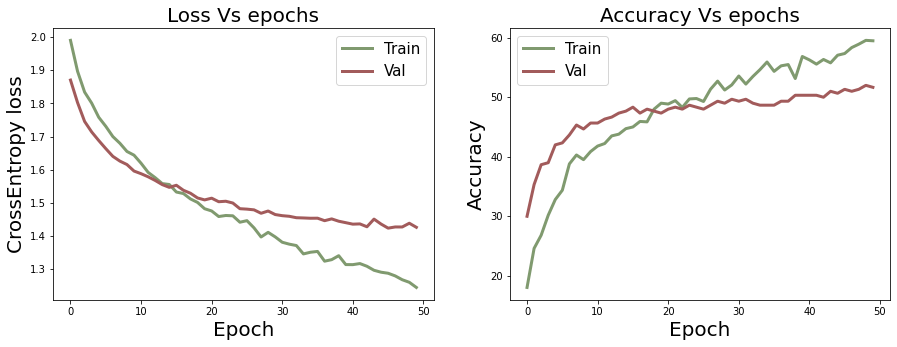

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.plot(train_loss_history,color = '#809A6F',lw=3, label='Train')
plt.plot(val_loss_history,color = '#A25B5B',lw=3, label='Val')
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('CrossEntropy loss',fontsize=20)
plt.title('Loss Vs epochs',fontsize=20)
plt.legend(fontsize=15)

plt.subplot(1,2,2)
plt.plot(train_accuracy_history,color = '#809A6F',lw=3, label='Train')
plt.plot(val_accuracy_history,color = '#A25B5B',lw=3, label='Val')
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.title('Accuracy Vs epochs',fontsize=20)
plt.legend(fontsize=15)

plt.show()

## **Model 2**:

In [ ]:
# Hyper-parameters
learning_rate = 0.0001
batch_size = 8
epoch_num = 50


# Model Defenition
class RockNet(nn.Module):
    
  def __init__(self):
    super(RockNet, self).__init__()
    self.flatten = nn.Flatten()


    self.model = nn.Sequential(
        nn.Linear(IMG_H * IMG_W * IMG_CH, 300),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.BatchNorm1d(300),
        nn.Linear(300, 300),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.BatchNorm1d(300),
        nn.Linear(300, 300),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.BatchNorm1d(300),
        nn.Linear(300, CLASS_NUM),
    )


  def forward(self, x):
    x = self.flatten(x) 
    logits = self.model(x)
    return logits

# Creat & Describe model structure
model_i = RockNet().to(device)
print(f"Model structure: {model_i}\n\n")

# Train and Validation loops
def train_loop(dataloader, model, loss_fn, optimizer):
  size = 0
  num_batches = len(dataloader)
  loss_vec , correct = 0, 0
  model.train()
  for batch, (X, y) in enumerate(dataloader):
      batch_loss , batch_accuracy = [],[]
      # move to device 
      X = X.to(device=device)
      y = y.to(device=device)
      # Compute prediction and loss
      pred = model(X)
      loss = loss_fn(pred, y)
      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # Modify print
      loss_vec += loss.item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
      size += len(y)
  print('Validation:\n','loss = ',loss_vec/ num_batches, 'accuracy = ',(correct/size)*100)
  return(loss_vec/ num_batches,(correct/size)*100)


def val_loop(dataloader, model, loss_fn):
  size = 0
  num_batches = len(dataloader)
  loss_vec , correct = 0, 0
  model.eval()
  with torch.no_grad(): 
      for X, y in dataloader:  
        # move to device 
        X = X.to(device=device)
        y = y.to(device=device)
        pred = model(X)
        loss = loss_fn(pred, y)
        # Modify print
        loss_vec += loss.item()    
        correct += (pred.argmax(1) == y).type(torch.float).sum().item() 
        size += len(y)
  print('Validation:\n','loss = ',loss_vec/ num_batches, 'accuracy = ',(correct/size)*100)
  return(loss_vec/ num_batches,(correct/size)*100)

# define Loss and Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_i.parameters(), lr=learning_rate)


# Run train & validation loops
train_loss_history,train_accuracy_history = [],[]
val_loss_history,val_accuracy_history = [],[]
for t in range(epoch_num):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loss , train_accuracy = train_loop(train_loader, model_i, loss_fn, optimizer)
  val_loss,val_accuracy = val_loop(validation_loader, model_i, loss_fn)
  train_loss_history.append(train_loss)
  train_accuracy_history.append(train_accuracy)
  val_loss_history.append(val_loss)
  val_accuracy_history.append(val_accuracy)
  print("\n-------------------------------")
print("Done!")

Model structure: RockNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=30000, out_features=300, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=300, out_features=300, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=300, out_features=300, bias=True)
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=300, out_features=7, bias=True)
  )
)


Epoch 1
-------------------------------
Validation:
 loss =  2.0345659147609365 accuracy =  17.33238231098431
Validation:
 loss =  1.8782315731048584 accuracy =  25.666666666666664

-----------------------------

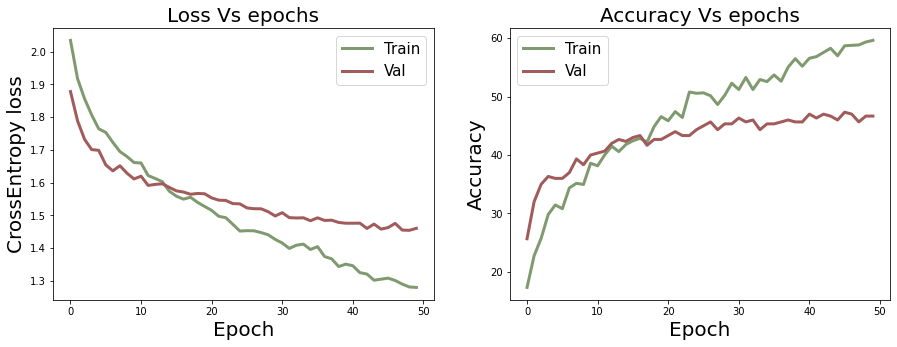

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
plt.plot(train_loss_history,color = '#809A6F',lw=3, label='Train')
plt.plot(val_loss_history,color = '#A25B5B',lw=3, label='Val')
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('CrossEntropy loss',fontsize=20)
plt.title('Loss Vs epochs',fontsize=20)
plt.legend(fontsize=15)

plt.subplot(1,2,2)
plt.plot(train_accuracy_history,color = '#809A6F',lw=3, label='Train')
plt.plot(val_accuracy_history,color = '#A25B5B',lw=3, label='Val')
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.title('Accuracy Vs epochs',fontsize=20)
plt.legend(fontsize=15)

plt.show()

# Evaluate final model with the test dataset

After you are satisfied with the final model, compute accuracy (and potentially other performance metrics) using the test dataset.

**lets evaluate the est dataset with Model2**

In [ ]:
def test_loop(dataloader, model):
  epoch_accuracy = 0
  total = 0

  model.eval()
  with torch.no_grad(): 
    for X, y in dataloader:
      # Put data on the same device like the model
      X = X.to(device=device)
      y = y.to(device=device)
      pred = model(X)

      # Update for average loss and accuracy
      total += len(y)
      epoch_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()

  epoch_accuracy /= total

  return epoch_accuracy

test_accuracy = test_loop(test_loader, model)
print(f'Test accuracy: {test_accuracy:.3f}')

Test accuracy: 0.458


Present a sample of images, their predicted vs. real class and accuracy for the sample. 

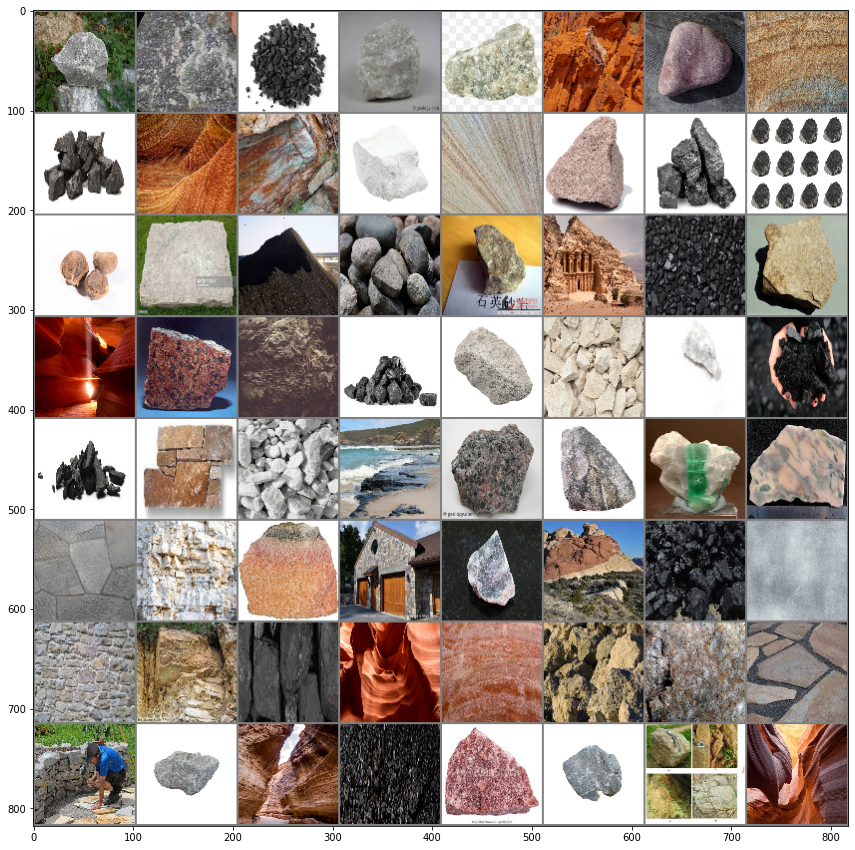

Accuracy for the batch:  0.50

    Label-Predicted
    ---------------
 1: Coal-Granite 
 2: Quartzite-Granite 
 3: Sandstone-Sandstone 
 4: Basalt-Basalt 
 5: Basalt-Basalt 
 6: Granite-Granite 
 7: Quartzite-Sandstone 
 8: Granite-Granite 



In [ ]:
def imshow(img):
  img = img * 0.29 + 0.5 # Unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

classes = all_data_dataset.classes

# Get a batch of test images and labels and show images
X, y = iter(test_loader).next()
plt.figure(figsize=(20, 15))
imshow(torchvision.utils.make_grid(X))

# Compute and present the label's class vs. the predicted class and the batch's accuracy.
model.eval()
with torch.no_grad():
  X = X.to(device=device)
  y = y.to(device=device)
  pred = model(X)
  predicted = pred.argmax(1)
  test_accuracy = (predicted == y).type(torch.float).sum().item() / len(y)
print(f'Accuracy for the batch: {test_accuracy : .2f}\n')
print('    Label-Predicted')
print('    ---------------')
print(''.join(f'{j+1:2d}: {classes[y[j]]:4s}-{classes[predicted[j]]:4s} \n' for j in range(batch_size)))


Confiusion Matrix:

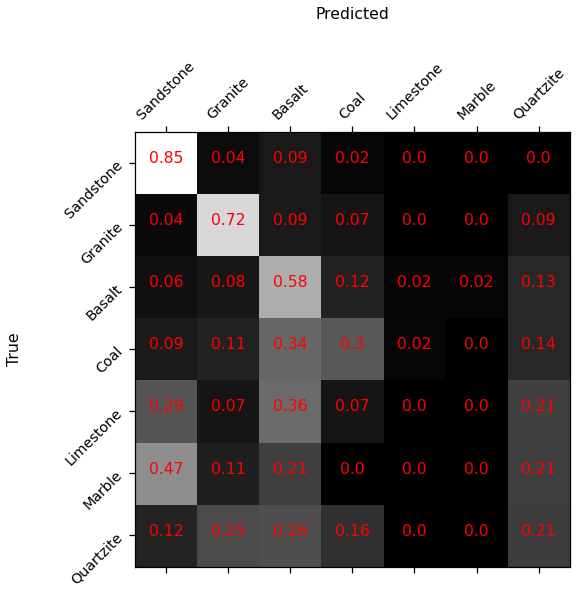

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set_context("notebook", font_scale=1.3)

# Creating the test data set in one tensor
true_y = []
model_y = []
model.eval()
with torch.no_grad(): 
  for X, y in test_loader:
    X = X.to(device=device)
    true_y.append(y.to(device=device))
    model_y.append(model(X).argmax(1))
true_y = torch.cat(true_y)
model_y = torch.cat(model_y)

# Creating normalized confusion matrix
conf_mx = confusion_matrix(true_y.cpu(), model_y.cpu()) #confusion matrix
row_sums = conf_mx.sum(axis=1, keepdims=True) 
norm_conf_mx = conf_mx / row_sums #normalized every value by the raw

# Plotting
fig, axis = plt.subplots(figsize=(8, 8))
axis.matshow(norm_conf_mx, cmap=plt.cm.gray)
axis.set_xlabel('Predicted', labelpad=40)
axis.xaxis.set_label_position('top')
axis.set_ylabel('True', labelpad=40)
axis.set_xticks(range(len(classes[:-1])))
axis.set_xticklabels(classes[:-1], rotation = 45)
axis.set_yticks(range(len(classes[:-1])))
axis.set_yticklabels(classes[:-1], rotation = 45)
for col in range(len(norm_conf_mx)):
  for row in range(len(norm_conf_mx)):
    axis.text(col, row, round(norm_conf_mx[row,col], 2), color='red', ha='center')